#### 환경설정

##### 1. Wandb

In [ ]:
import wandb

# wandb 로그인
wandb.login(key="")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/HyeonSeok/.netrc
wandb: Currently logged in as: vanillahub12 (boaz_woony-boaz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

##### 2. 라이브러리 로드

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
import math
import random
import pickle
import wandb
from tqdm import tqdm
from datetime import datetime
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import torchvision
import torchvision.models as models
from torch import Tensor
from torchsummary import summary
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.manifold import TSNE

##### 3. 경로 설정

In [4]:
# from google.colab import drive

# drive.mount('/content/drive')

ROOT = "/home/HyeonSeok/BOAZ-Chungzins/data/raw"
CHECKPOINT_PATH = "/home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint"
PICKLE_PATH = "/home/HyeonSeok/BOAZ-Chungzins/save_path/pickle"
text = "/home/HyeonSeok/BOAZ-Chungzins/data/metadata/train_test_split.txt"

##### 4. Seed 설정

In [5]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything(42) # Seed 고정

## 1. Data Load

#### 1.1 Data Load

In [6]:
# WAV 파일이 있는 디렉토리 경로
data_dir = ROOT
txt_dir = ROOT

df = pd.read_csv(text, sep='\t', header=None)

# 컬럼 이름 변경
df.columns = ['filename', 'set']

# train, test split
train_df = df[df['set'] == 'train']
test_df = df[df['set'] == 'test']

# filename list
train_list = sorted(train_df['filename'].tolist())
test_list = sorted(test_df['filename'].tolist())

print(f'Train :{len(train_list)}, Test: {len(test_list)}, Total: {len(train_list) + len(test_list)}')

Train :539, Test: 381, Total: 920


#### 1.2 Pretext-Finetune Split

In [7]:
# shuffle train data
df_shuffled = train_df.sample(frac=1, random_state=42)

# split ratio
train_size = int(0.8 * len(df_shuffled))

# pretrain, finetune split
pretrain_df = df_shuffled[:train_size]
finetune_df = df_shuffled[train_size:]

# filename list (pretext_list -> pretrain list)
pretrain_list = sorted(pretrain_df['filename'].tolist())
finetune_list = sorted(finetune_df['filename'].tolist())

# patient id list
pretrain_patient_list = []
for filename in pretrain_list:
    number = int(filename.split('_')[0])
    pretrain_patient_list.append(number)

finetune_patient_list = []
for filename in finetune_list:
    number = int(filename.split('_')[0])
    finetune_patient_list.append(number)

pretrain_patient_counts = pd.Series(pretrain_patient_list).value_counts()
finetune_patient_counts = pd.Series(finetune_patient_list).value_counts()

print(f"[Pretrain] 환자 수: {len(pretrain_patient_counts.index)}, 샘플 수: {pretrain_patient_counts.sum()}")
print(f"[Finetune] 환자 수: {len(finetune_patient_counts.index)}, 샘플 수: {finetune_patient_counts.sum()}")

[Pretrain] 환자 수: 74, 샘플 수: 431
[Finetune] 환자 수: 43, 샘플 수: 108


## 2. Data Preprocessing

#### 2.1 Args

        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)

In [8]:
class Args:
    # Audio & Spectrogram
    target_sr = 8000    # 8KHz
    frame_size = 1024
    hop_length = 512    # frame_size 절반
    n_mels = 256
    target_sec = 8

    # Augmentation
    time_mask_param = 0.5
    freq_mask_param = 0.5

    # Train
    lr = 0.03
    warm = True                     # warm-up 사용 여부
    warm_epochs = 10                # warm-up 적용할 초기 epoch 수
    warmup_from = lr * 0.1          # warm-up 시작 learning rate (보통 lr의 10%)
    warmup_to = lr

    batch_size = 128
    workers = 2
    epochs = 300
    weight_decay = 1e-4

    resume = None
    schedule=[120, 160] # schedule

    # MLS
    K = 512
    momentum = 0.999
    T = 0.07
    dim_prj = 128
    top_k = 20
    lambda_bce = 0.3
    out_dim = 2048

    # Linear Evaluation
    ft_epochs = 100

    # etc
    gpu = 0
    data = "./data_path"
    seed=42

args = Args()

#### 2.2 Utils (func)

In [9]:
import torch.nn.functional as F
import random

def convert_matrix_to_vector(labels):
    """Nx2 행렬을 -> 다중 클래스 list로 변환

    (Before)
    [[0. 0.]  ← 1번째 샘플 (Normal)
    [1. 0.]   ← 2번째 샘플 (Crackle)
    ...
    [0. 1.]   ← (N-1)번째 샘플 (Wheeze)
    [1. 1.]]  ← N번째 샘플 (Both)

    (After)
    [0, 1, ..., 2, 3]
    """
    
    labels = labels.cpu().numpy() if torch.is_tensor(labels) else labels
    return torch.tensor((labels[:, 0] * 1 + labels[:, 1] * 2).astype(int))

# cycle의 클래스를 추출
def get_class(cr, wh):
    if cr == 1 and wh == 1:
        return 3
    elif cr == 0 and wh == 1:
        return 2
    elif cr == 1 and wh == 0:
        return 1
    elif cr == 0 and wh == 0:
        return 0
    else:
        return -1

# def normalize_mel_binwise(mel_db: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
#     """
#     mel_db: Tensor of shape (B, n_mels, time) 또는 (1, n_mels, time)
#     각 mel bin(n_mels)을 따라 평균 0, std 1로 정규화
#     """
#     assert mel_db.dim() == 3, f"Expected 3D tensor (B, n_mels, time), got {mel_db.shape}"

#     mean = mel_db.mean(dim=2, keepdim=True)  # time 축 기준 평균 → (B, n_mels, 1)
#     std = mel_db.std(dim=2, keepdim=True) + eps
#     mel_norm = (mel_db - mean) / std
#     return mel_norm  # shape 유지: (B, n_mels, time)


# mel spectrogram 생성, 1차 정규화
def generate_mel_spectrogram(waveform, sample_rate, frame_size, hop_length, n_mels):
    if hop_length is None:
        hop_length = frame_size // 2
    mel_spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=frame_size,
        hop_length=hop_length,
        n_mels=n_mels
    )
    mel_spectrogram = mel_spec_transform(waveform)
    mel_db = T.AmplitudeToDB()(mel_spectrogram)

    return mel_db
    
# Cycle Repeat 또는 Crop
def repeat_or_truncate_segment(mel_segment, target_frames):
    current_frames = mel_segment.shape[-1]
    if current_frames >= target_frames:
        return mel_segment[:, :, :target_frames]
    else:
        repeat_ratio = math.ceil(target_frames / current_frames)
        mel_segment = mel_segment.repeat(1, 1, repeat_ratio)
        return mel_segment[:, :, :target_frames]

# def preprocess_waveform_segment(waveform, unit_length):

#     """unit_length 기준으로 waveform을 repeat + padding 또는 crop하여 길이 정규화"""
#     waveform = waveform.squeeze(0)  # (1, L) → (L,) 로 바꿔도 무방
#     length_adj = unit_length - len(waveform)

#     if length_adj > 0:
#         # waveform이 너무 짧은 경우 → repeat + zero-padding
#         half_unit = unit_length // 2

#         if length_adj < half_unit:
#             # 길이 차이가 작으면 단순 padding
#             half_adj = length_adj // 2
#             waveform = F.pad(waveform, (half_adj, length_adj - half_adj))
#         else:
#             # 반복 후 부족한 부분 padding
#             repeat_factor = unit_length // len(waveform)
#             waveform = waveform.repeat(repeat_factor)[:unit_length]
#             remaining = unit_length - len(waveform)
#             half_pad = remaining // 2
#             waveform = F.pad(waveform, (half_pad, remaining - half_pad))
#     else:
#         # waveform이 너무 길면 앞쪽 1/4 내에서 랜덤 crop
#         length_adj = len(waveform) - unit_length
#         start = random.randint(0, length_adj // 4)
#         waveform = waveform[start:start + unit_length]

#     return waveform.unsqueeze(0)  # 다시 (1, L)로

def preprocess_waveform_with_fade_repeat(waveform, unit_length, fade_ratio=0.1):
    """
    길이 unit_length까지 반복하며 fade-in/out으로 연결하는 방식의 padding
    waveform: (1, L) or (L,)
    fade_ratio: 각 반복 연결부에서 fade-in/out 적용 비율 (0.1 → 10%)
    """
    if waveform.dim() == 2:
        waveform = waveform.squeeze(0)  # (1, L) → (L,)

    orig_len = len(waveform)
    fade_len = int(orig_len * fade_ratio)

    if orig_len >= unit_length:
        # 너무 길면 crop
        length_adj = orig_len - unit_length
        start = random.randint(0, length_adj // 4)
        waveform = waveform[start:start + unit_length]
        return waveform.unsqueeze(0)

    # 만들고자 하는 길이만큼 반복
    full_wave = waveform.clone()
    while len(full_wave) < unit_length:
        next_cycle = waveform.clone()

        # fade-out 마지막 구간
        fade_out = torch.linspace(1.0, 0.0, fade_len)
        full_wave[-fade_len:] *= fade_out

        # fade-in 앞부분
        fade_in = torch.linspace(0.0, 1.0, fade_len)
        next_cycle[:fade_len] *= fade_in

        # 이어붙이기
        full_wave = torch.cat([full_wave, next_cycle], dim=0)

    # 최종 길이 맞추기
    waveform = full_wave[:unit_length]
    return waveform.unsqueeze(0)  # (1, L)

# 데이터 Spec Augmentation ( 0~80% Random Masking )
def apply_spec_augment(mel_segment):

    M = mel_segment.shape[-1]
    F = mel_segment.shape[-2]

    # torchaudio의 마스킹은 0부터 mask_param까지 균등분포에서 랜덤하게 길이를 선택
    time_masking = T.TimeMasking(time_mask_param=int(M * 0.8))
    freq_masking = T.FrequencyMasking(freq_mask_param=int(F * 0.8) )

    aug1 = freq_masking(mel_segment.clone())
    aug2 = time_masking(mel_segment.clone())
    aug3 = freq_masking(time_masking(mel_segment.clone()))

    return aug1, aug2, aug3

# Waveform resample
def resample_waveform(waveform, orig_sr, target_sr=args.target_sr):
    if orig_sr != target_sr:
        resampler = torchaudio.transforms.Resample(
            orig_freq=orig_sr,
            new_freq=target_sr
        )
        return resampler(waveform), target_sr
    return waveform, orig_sr

# Normalize - Mean/Std
def get_mean_and_std(dataset):
    """ 전체 mel-spectrogram에서 mean과 std 계산 """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

    cnt = 0
    fst_moment = torch.zeros(1)
    snd_moment = torch.zeros(1)
    for inputs, _, _ in tqdm(dataloader, desc="[Calculating Mean/Std]"):
        b, c, h, w = inputs.shape  # inputs: [1, 1, n_mels, time]
        nb_pixels = b * h * w

        fst_moment += torch.sum(inputs, dim=[0, 2, 3])
        snd_moment += torch.sum(inputs**2, dim=[0, 2, 3])
        cnt += nb_pixels

    mean = fst_moment / cnt
    std = torch.sqrt(snd_moment / cnt - mean**2)
    return mean.item(), std.item()

In [10]:
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
import numpy as np
import random

# -------------------- Augmentation functions (ICBHI 멜스펙트로그램에 최적화) --------------------

def spec_augment(mel, time_mask_ratio=0.15, freq_mask_ratio=0.15):
    """
    SpecAugment: 시간/주파수 영역 마스킹
    - 시간축 마스킹: 63 * 0.15 ≈ 9 프레임
    - 주파수 마스킹: 128 * 0.1 ≈ 12 채널
    """
    M = mel.shape[-1]  # 시간 축
    F = mel.shape[-2]  # 주파수 축

    time_masking = T.TimeMasking(time_mask_param=max(1, int(M * time_mask_ratio)))
    freq_masking = T.FrequencyMasking(freq_mask_param=max(1, int(F * freq_mask_ratio)))

    mel = freq_masking(mel.clone())
    mel = time_masking(mel)
    return mel

def add_noise(mel, noise_level=0.001):
    """
    노이즈 추가: 적당한 수준의 표준 정규분포 노이즈 (너무 높으면 손실 커짐)
    """
    noise = torch.randn_like(mel) * noise_level
    return mel + noise

def pitch_shift(mel, n_steps=2):
    """
    주파수 축 순환 이동 (mel axis). shape은 그대로 유지됨.
    n_steps=2면 ±2 멜 채널만 이동.
    """
    shift = random.randint(-n_steps, n_steps)
    if shift == 0:
        return mel
    if shift > 0:
        mel = torch.cat([mel[:, :, shift:, :], mel[:, :, :shift, :]], dim=2)
    else:
        shift = abs(shift)
        mel = torch.cat([mel[:, :, -shift:, :], mel[:, :, :-shift, :]], dim=2)
    return mel

def time_stretch(mel, min_rate=0.95, max_rate=1.05):
    """
    시간 축 길이 조절. 너무 심하지 않게 ±5% 범위로만 조정.
    - shape 유지 위해 interpolation 후 crop/pad
    """
    rate = random.uniform(min_rate, max_rate)
    if rate == 1.0:
        return mel

    orig_size = mel.shape[-1]
    target_size = int(orig_size * rate)

    mel_stretched = F.interpolate(
        mel, size=(mel.shape[-2], target_size),  # (mel_bins, time)
        mode='bilinear',
        align_corners=False
    )

    if target_size > orig_size:
        return mel_stretched[..., :orig_size]
    else:
        pad = orig_size - target_size
        return F.pad(mel_stretched, (0, pad))

# -------------------- Dispatcher --------------------

AUGMENTATION_FUNCTIONS_TORCH = {
    "spec_augment": spec_augment,
    "add_noise": add_noise,
    "pitch_shift": pitch_shift,
    "time_stretch": time_stretch
}

def apply_augmentations_torch(x, methods=[], **kwargs):
    for method in methods:
        func = AUGMENTATION_FUNCTIONS_TORCH.get(method)
        if func is None:
            raise ValueError(f"Unknown augmentation: {method}")
        x = func(x, **kwargs.get(method, {}))
    return x

In [11]:
def aug(repeat_mel):
    # 먼저 복사본 준비
    mel1 = repeat_mel.clone()
    mel2 = repeat_mel.clone()

    # 각각 다른 증강 A, B 적용
    aug1 = apply_augmentations_torch(mel1, methods=["add_noise"], add_noise={"noise_level": 0.005})
    aug2 = apply_augmentations_torch(mel2, methods=["time_stretch"], time_stretch={"min_rate": 0.9, "max_rate": 1.1})
    # aug3 = apply_augmentations_torch(mel3, methods=["pitch_shift"], pitch_shift={"n_steps": 2})

    # # 각 결과에 spec_augment 추가 적용
    # aug1 = spec_augment(aug1, time_mask_ratio=0.6, freq_mask_ratio=0.4)
    # aug2 = spec_augment(aug2, time_mask_ratio=0.6, freq_mask_ratio=0.4)
    # aug3_spec = spec_augment(aug3, time_mask_ratio=0.6, freq_mask_ratio=0.4)

    return aug1, aug2, None


def window_mix(repeat_mel, classwise_cycle_list):
    
    mel1 = repeat_mel.clone()
    mel2 = repeat_mel.clone()

    B, C, F, T = repeat_mel.shape  # 4D: [B, 1, F, T]
    normal_cycle_list = classwise_cycle_list[0]

    # mel1 증강
    for _ in range(random.randint(1, 3)):
        window_width = random.randint(int(T * 0.1), int(T * 0.4))
        start = random.randint(int(T * 0.1), T - window_width)
        end = start + window_width

        random_normal_cycle1 = random.choice(normal_cycle_list)[0]
        random_normal_cycle1 = random_normal_cycle1.expand(B, -1, -1, -1)
        mel1[:, :, :, start:end] = random_normal_cycle1[:, :, :, start:end]

    # mel2 증강
    for _ in range(random.randint(1, 3)):
        window_width = random.randint(int(T * 0.1), int(T * 0.4))
        start = random.randint(int(T * 0.1), T - window_width)
        end = start + window_width

        random_normal_cycle2 = random.choice(normal_cycle_list)[0]
        random_normal_cycle2 = random_normal_cycle2.expand(B, -1, -1, -1)
        mel2[:, :, :, start:end] = random_normal_cycle2[:, :, :, start:end]

    return mel1, mel2, None


def get_timestamp():
    """Outputs current time in KST like 2404070830"""
    kst_time = datetime.now(ZoneInfo("Asia/Seoul"))
    return kst_time.strftime('%y%m%d%H%M')

# Origin
# def aug(repeat_mel):
#     aug1, aug2, aug3 = apply_spec_augment(repeat_mel)
#     return aug1, aug2, aug3

#### 2.3 CycleDataset

OriginalCycleDataset - 기존에 사용하던 것

In [12]:
import os
import torch
import torchaudio
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm import tqdm

class OriginalCycleDataset(Dataset):
    def __init__(self, filename_list, wav_dir, txt_dir, target_sec=args.target_sec, target_sr=args.target_sr, frame_size=args.frame_size, hop_length=args.hop_length, n_mels=args.n_mels, mean=None, std=None):
        self.filename_list = filename_list
        self.wav_dir = wav_dir
        self.txt_dir = txt_dir
        self.target_sec = target_sec
        self.target_sr = target_sr
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mean = mean
        self.std = std

        self.cycle_list = []

        print("[INFO] Preprocessing cycles...")
        for filename in tqdm(self.filename_list):
            txt_path = os.path.join(self.txt_dir, filename + '.txt')
            wav_path = os.path.join(self.wav_dir, filename + '.wav')

            if not os.path.exists(txt_path):
                print(f"[WARNING] Missing file: {txt_path}")
            if not os.path.exists(wav_path):
                print(f"[WARNING] Missing file: {wav_path}")

            # Load annotation
            cycle_data = np.loadtxt(txt_path, usecols=(0, 1))
            lung_label = np.loadtxt(txt_path, usecols=(2, 3))

            # Load waveform
            waveform, orig_sr = torchaudio.load(wav_path)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)  # Stereo to mono

            # Resample to target sample rate (4kHz)
            waveform, sample_rate = resample_waveform(waveform, orig_sr, self.target_sr)

            for idx in range(len(cycle_data)):
                # 호흡 주기 start, end
                start_sample = int(cycle_data[idx, 0] * sample_rate)
                end_sample = int(cycle_data[idx, 1] * sample_rate)
                lung_duration = cycle_data[idx, 1] - cycle_data[idx, 0]

                if end_sample <= start_sample:
                    continue  # 잘못된 구간 스킵

                # Waveform repeat + padding 후 Mel_db
                cycle_wave = waveform[:, start_sample:end_sample]
                normed_wave = preprocess_waveform_with_fade_repeat(cycle_wave, unit_length=int(self.target_sec * self.target_sr))
                mel = generate_mel_spectrogram(normed_wave, sample_rate, frame_size=self.frame_size, hop_length=self.hop_length, n_mels=self.n_mels)

                # 정규화
                if self.mean is not None and self.std is not None:
                    mel = (mel - self.mean) / self.std
                    # print(f"mean: {self.mean} / std: {self.std}")

                # crackle, wheeze -> class
                cr = int(lung_label[idx, 0])
                wh = int(lung_label[idx, 1])
                label = get_class(cr, wh)

                multi_label = torch.tensor([
                    float(label in [1, 3]),
                    float(label in [2, 3])
                ])  # 변환된 multi-label 반환

                # meta_data
                meta_data = (filename, lung_duration)

                self.cycle_list.append((mel, multi_label, meta_data))

        print(f"[INFO] Total cycles collected: {len(self.cycle_list)}")

    def __len__(self):
        return len(self.cycle_list)

    def __getitem__(self, idx):
        mel, label, meta_data = self.cycle_list[idx]
        return mel, label, meta_data

NewCycleDataset - 2개의 cycle을 concat하여 새로운 데이터 생성  
- 도입 목적: 데이터 불균형 해소, 데이터 양 증가

In [13]:
import os
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm

# train data에만 사용
class RawCycleDataset(Dataset):
    def __init__(self, filename_list, wav_dir, txt_dir,
                 target_sr=args.target_sr):
        self.filename_list = filename_list
        self.wav_dir = wav_dir
        self.txt_dir = txt_dir
        self.target_sr = target_sr

        self.cycle_list = []

        print("[INFO] Loading raw waveform cycles...")
        for filename in tqdm(self.filename_list):
            txt_path = os.path.join(self.txt_dir, filename + '.txt')
            wav_path = os.path.join(self.wav_dir, filename + '.wav')

            if not os.path.exists(txt_path):
                print(f"[WARNING] Missing file: {txt_path}")
            if not os.path.exists(wav_path):
                print(f"[WARNING] Missing file: {wav_path}")

            # Load annotations
            cycle_data = np.loadtxt(txt_path, usecols=(0, 1))
            lung_label = np.loadtxt(txt_path, usecols=(2, 3))

            # Load audio
            waveform, orig_sr = torchaudio.load(wav_path)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)  # Stereo to mono

            # Resample
            waveform, sample_rate = resample_waveform(waveform, orig_sr, self.target_sr)

            for idx in range(len(cycle_data)):
                # 호흡 주기 start, end
                start_sample = int(cycle_data[idx, 0] * sample_rate)
                end_sample = int(cycle_data[idx, 1] * sample_rate)
                lung_duration = cycle_data[idx, 1] - cycle_data[idx, 0]

                if end_sample <= start_sample:
                    continue  # 잘못된 구간 스킵

                # cycle_wave만 반환
                cycle_wave = waveform[:, start_sample:end_sample]

                cr = int(lung_label[idx, 0])
                wh = int(lung_label[idx, 1])
                label = get_class(cr, wh)  # 0: normal, 1: crackle, 2: wheeze, 3: both

                # meta_data
                meta_data = (filename, lung_duration)

                self.cycle_list.append((cycle_wave, label, meta_data))

        print(f"[INFO] Total raw waveform cycles: {len(self.cycle_list)}")

    def __len__(self):
        return len(self.cycle_list)

    def __getitem__(self, idx):
        waveform, label, meta_data = self.cycle_list[idx]
        return waveform, label, meta_data

In [14]:
# 기존 cycle_list, classwise_cycle_list 준비 (split before class)
from collections import defaultdict

def group_by_class(cycle_list):
    '''
    클래스별로 cycle_list를 분리하여 반환

    Args:
        cycle_list: CycleDataset -> (waveform, label, meta_data) 리스트
        
    Returns:
        classwise_dict: 클래스별 리스트를 모은 dict
        (0: Normal, 1: Crackle, 2: Wheeze, 3: Both)
    '''
    classwise_dict = defaultdict(list)

    for sample in cycle_list:
        # 각 cycle의 class
        cls = sample[1]
        
        # 클래스에 대응하는 새로운 list에 append
        classwise_dict[cls].append(sample)
        
    return classwise_dict

def concat_augment(cycle_list, classwise_cycle_list, scale=1.5):
    '''
    데이터를 concat하여 만든 새로운 데이터를 포함한 cycle_list 생성
    cycle_list의 각 원소는 다시 (waveform, label, meta_data)로 구성
    
    Args:
        cycle_list: 기존 cycle_list
        classwise_cycle_list (dict): 현재 클래스에 대응하는 cycle_list
        scale: normal 데이터를 더 늘릴 비율 (normal 데이터 수를 기준으로 abnormal 데이터가 만들어짐)

    Returns:
        new_cycle_list: 새로 만들어진 cycle_list
    '''
    new_samples = []

    # 기준: normal 클래스 길이
    max_len = len(classwise_cycle_list[0])

    for class_id in range(4):
        current_class = classwise_cycle_list[class_id]
        n_to_add = scale * max_len - len(current_class)   # 클래스별로 데이터 수를 동일하게 맞추기 위해 샘플링을 반복할 횟수

        for idx in range(n_to_add):
            aug_prob = random.random()

            if class_id == 0:
                sample_i = random.choice(current_class)
                sample_j = random.choice(current_class)

            elif class_id == 1:
                if aug_prob < 0.6:
                    sample_i = random.choice(current_class)
                    sample_j = random.choice(current_class)
                elif aug_prob < 0.8:
                    sample_i = random.choice(current_class)
                    sample_j = random.choice(classwise_cycle_list[0])
                else:
                    sample_i = random.choice(classwise_cycle_list[0])
                    sample_j = random.choice(current_class)

            elif class_id == 2:
                if aug_prob < 0.6:
                    sample_i = random.choice(current_class)
                    sample_j = random.choice(current_class)
                elif aug_prob < 0.8:
                    sample_i = random.choice(current_class)
                    sample_j = random.choice(classwise_cycle_list[0])
                else:
                    sample_i = random.choice(classwise_cycle_list[0])
                    sample_j = random.choice(current_class)

            else:
                if aug_prob < 0.5:
                    sample_i = random.choice(current_class)
                    sample_j = random.choice(current_class)
                elif aug_prob < 0.7:
                    sample_i = random.choice(classwise_cycle_list[1])
                    sample_j = random.choice(classwise_cycle_list[2])
                elif aug_prob < 0.8:
                    sample_i = random.choice(classwise_cycle_list[2])
                    sample_j = random.choice(classwise_cycle_list[1])
                elif aug_prob < 0.9:
                    sample_i = random.choice(current_class)
                    sample_j = random.choice(classwise_cycle_list[0])
                else:
                    sample_i = random.choice(classwise_cycle_list[0])
                    sample_j = random.choice(current_class)

            new_audio = torch.cat([sample_i[0], sample_j[0]], dim=1)  # dim=1: 시간축 기준
            fname = f"{sample_i[2]}-{sample_j[2]}"
            meta = (fname, 0.0)
            new_samples.append((new_audio, class_id, meta))

    new_cycle_list = cycle_list + new_samples
    random.shuffle(new_cycle_list)  # 리스트 원소 혼합 (in-place)

    return new_cycle_list

In [15]:
seed_everything(args.seed)
wav_dir = ROOT
txt_dir = ROOT

raw_train_dataset = RawCycleDataset(train_list, wav_dir, txt_dir)
raw_train_cycle_list = raw_train_dataset.cycle_list

# classwise 분리
raw_train_classwise_dict = group_by_class(raw_train_cycle_list)

# concat augment 적용
train_augmented = concat_augment(raw_train_cycle_list, raw_train_classwise_dict, scale=1)

[INFO] Loading raw waveform cycles...


100%|██████████| 539/539 [00:11<00:00, 48.05it/s]


[INFO] Total raw waveform cycles: 4142


In [16]:
import torch
from torch.utils.data import Dataset

class NewCycleDataset(Dataset):
    def __init__(self, augmented_list, target_sec=args.target_sec, target_sr=args.target_sr, frame_size=args.frame_size, hop_length=args.hop_length, n_mels=args.n_mels, mean=None, std=None):

        """
        augmented_list: [(waveform: np.ndarray, label: int, meta), ...]
        """

        self.target_sec = target_sec
        self.target_sr = target_sr
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mean = mean
        self.std = std

        self.cycle_list = []

        print("[INFO] Processing TrainDataset from augmented waveform list...")

        for waveform, label, meta in augmented_list:

            # (1) crop or pad to fixed length using utility
            normed_wave = preprocess_waveform_with_fade_repeat(
                waveform, unit_length=int(self.target_sec * self.target_sr)
            )

            # (2) mel transform
            mel = generate_mel_spectrogram(
                normed_wave,
                sample_rate=self.target_sr,
                frame_size=self.frame_size,
                hop_length=self.hop_length,
                n_mels=self.n_mels
            )  # [n_mels, T]

            # (3) 정규화
            if self.mean is not None and self.std is not None:
                mel = (mel - self.mean) / self.std
                # print(f"mean: {self.mean} / std: {self.std}")

            # (4) multi-label 생성: [crackle, wheeze]
            multi_label = torch.tensor([
                float(label in [1, 3]),
                float(label in [2, 3])
            ])

            self.cycle_list.append((mel, multi_label, meta))

        print(f"[INFO] Total mel samples in Train Dataset: {len(self.cycle_list)}")

    def __len__(self):
        return len(self.cycle_list)

    def __getitem__(self, idx):
        mel, multi_label, meta = self.cycle_list[idx]
        return mel, multi_label, meta

In [17]:
# train 데이터 (정규화 전)
normless_dataset = NewCycleDataset(train_augmented)

[INFO] Processing TrainDataset from augmented waveform list...
[INFO] Total mel samples in Train Dataset: 8252


In [18]:
mean, std = get_mean_and_std(normless_dataset)

[Calculating Mean/Std]: 100%|██████████| 8252/8252 [00:13<00:00, 616.96it/s]


In [19]:
# 정규화된 train 데이터
train_dataset = NewCycleDataset(train_augmented, mean=mean, std=std)

[INFO] Processing TrainDataset from augmented waveform list...
[INFO] Total mel samples in Train Dataset: 8252


window_mix를 위한 classwise mel cycle dataset 생성

In [20]:
# train 데이터에서는 multi label을 반환하도록 되어있음.. 단일 class label로 다시 변환

def multilabel_to_class(label_tensor):
    crackle = label_tensor[0].item()
    wheeze = label_tensor[1].item()
    if crackle and wheeze:
        return 3  # Both
    elif crackle:
        return 1  # Crackle
    elif wheeze:
        return 2  # Wheeze
    else:
        return 0  # Normal

def group_by_class_multilabel(cycle_list):
    from collections import defaultdict

    classwise_dict = defaultdict(list)

    for sample in cycle_list:
        label_tensor = sample[1]
        cls = multilabel_to_class(label_tensor)
        classwise_dict[cls].append(sample)

    return classwise_dict

In [21]:
mel_train_classwise_dict = group_by_class_multilabel(train_dataset.cycle_list)

#### 2.4 Pickle

##### Pickle.dump

CycleDataset 객체 생성

In [22]:
# # 테스트 데이터셋 생성
# import random
# import matplotlib.pyplot as plt
# import librosa.display

# wav_dir = ROOT
# txt_dir = ROOT

# test_dataset = OriginalCycleDataset(test_list, wav_dir, txt_dir, mean=mean, std=std)

pickle로 train_dataset, test_dataset 외부 저장

In [23]:
pickle_name = f'concat_datasets.2_{args.target_sr//1000}kHz_{args.frame_size}_2_{args.n_mels}'

In [24]:
# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset
# }

# save_path = os.path.join(PICKLE_PATH, pickle_name + '.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(pickle_dict, f)

In [25]:
# # 2. 간단 통계
# print(f"Total cycles: {len(train_dataset)}")

# label_counter = [0] * 4  # normal, crackle, wheeze, both
# for _, multi_label,_ in train_dataset:
#     if torch.equal(multi_label, torch.tensor([0., 0.])):
#         label_counter[0] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 0.])):
#         label_counter[1] += 1
#     elif torch.equal(multi_label, torch.tensor([0., 1.])):
#         label_counter[2] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 1.])):
#         label_counter[3] += 1

# for idx, count in enumerate(label_counter):
#     print(f"Class {idx}: {count} cycles")

##### Pickle.load
저장된 train_dataset, test_dataset을 로드  
(> Aug 는 Moco 모델에서 사용)

In [27]:
import os
import torch
import torchaudio
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm import tqdm

class CycleDataset(Dataset):
    def __init__(self, filename_list, wav_dir, txt_dir, target_sec=args.target_sec, target_sr=args.target_sr, frame_size=args.frame_size, hop_length=args.hop_length, n_mels=args.n_mels, mean=None, std=None):
        self.filename_list = filename_list
        self.wav_dir = wav_dir
        self.txt_dir = txt_dir
        self.target_sec = target_sec
        self.target_sr = target_sr
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mean = mean
        self.std = std

        self.cycle_list = []

        print("[INFO] Preprocessing cycles...")
        for filename in tqdm(self.filename_list):
            txt_path = os.path.join(self.txt_dir, filename + '.txt')
            wav_path = os.path.join(self.wav_dir, filename + '.wav')

            if not os.path.exists(txt_path):
                print(f"[WARNING] Missing file: {txt_path}")
            if not os.path.exists(wav_path):
                print(f"[WARNING] Missing file: {wav_path}")

            # Load annotation
            cycle_data = np.loadtxt(txt_path, usecols=(0, 1))
            lung_label = np.loadtxt(txt_path, usecols=(2, 3))

            # Load waveform
            waveform, orig_sr = torchaudio.load(wav_path)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)  # Stereo to mono
                print(' waveform.shape[0] > 1:')

            # Resample to target sample rate (4kHz)
            waveform, sample_rate = resample_waveform(waveform, orig_sr, self.target_sr)

            for idx in range(len(cycle_data)):
                # 호흡 주기 start, end
                start_sample = int(cycle_data[idx, 0] * sample_rate)
                end_sample = int(cycle_data[idx, 1] * sample_rate)
                lung_duration = cycle_data[idx, 1] - cycle_data[idx, 0]

                if end_sample <= start_sample:
                    print('end_sample <= start_sample:')
                    continue  # 잘못된 구간 스킵

                # Waveform repeat + padding 후 Mel_db
                cycle_wave = waveform[:, start_sample:end_sample]
                seg_wave = preprocess_waveform_segment(cycle_wave, unit_length=int(self.target_sec * self.target_sr))
                mel = generate_mel_spectrogram(seg_wave, sample_rate, frame_size=self.frame_size, hop_length=self.hop_length, n_mels=self.n_mels)

                # 정규화
                if self.mean is not None and self.std is not None:
                    mask_value = -100.0 # mel db 에서 마스킹된 값
                    mask = (mel == mask_value)
                    mel = (mel - mean) / std
                    mel[mask] = 0.0
                    
                # crackle, wheeze -> class
                cr = int(lung_label[idx, 0])
                wh = int(lung_label[idx, 1])
                label = get_class(cr, wh)

                multi_label = torch.tensor([
                    float(label in [1, 3]),
                    float(label in [2, 3])
                ])  # 변환된 multi-label 반환

                # meta_data
                meta_data = (filename, lung_duration)

                self.cycle_list.append((mel, multi_label, meta_data))

        print(f"[INFO] Total cycles collected: {len(self.cycle_list)}")

    def __len__(self):
        return len(self.cycle_list)

    def __getitem__(self, idx):
        mel, label, meta_data = self.cycle_list[idx]
        return mel, label, meta_data

In [32]:
save_path = os.path.join(PICKLE_PATH, 'MLS_age_gen_4kHz_1024win_512hop_128mel_8s.pkl')
with open(save_path, 'rb') as f:
    pickle_dict = pickle.load(f)

train_dataset = pickle_dict['train_dataset']
test_dataset = pickle_dict['test_dataset']

print(f"[Train] Cycles: {len(train_dataset)}")
print(f"[Test] Cycles: {len(test_dataset)}")

[Train] Cycles: 4142
[Test] Cycles: 2756


#### 2.5 DataLoader

코드 실행 환경에 따라 num_workers를 적절한 값으로 지정해주세요!

In [33]:
train_loader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    num_workers=4,
    drop_last=True,
    pin_memory=True,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    num_workers=4,
    pin_memory=True,
    shuffle=False
)

label 분포 확인 (단순 참고용, 실제 환경에서는 pretrain set의 label 분포가 어떤지 알 수 없음)

In [34]:
from collections import Counter

# label
# labels = torch.stack([multi_label for _, multi_label, _ in train_dataset])

# train 데이터셋의 라벨 분포 출력
train_labels = torch.stack([multi_label for _, multi_label, _ in train_dataset])
train_labels_class = (
    train_labels[:, 0].long() * 1 +  # crackle bit → *1
    train_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

# test 데이터셋의 라벨 분포 출력
test_labels = torch.stack([multi_label for _, multi_label, _ in test_dataset])
test_labels_class = (
    test_labels[:, 0].long() * 1 +  # crackle bit → *1
    test_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

print(f"Train sample: {len(train_labels_class)}")
print("Train label distribution:", Counter(train_labels_class.tolist()))
print(f"\nTest sample: {len(test_labels_class)}")
print("Test label distribution:", Counter(test_labels_class.tolist()))

Train sample: 4142
Train label distribution: Counter({0: 2063, 1: 1215, 2: 501, 3: 363})

Test sample: 2756
Test label distribution: Counter({0: 1579, 1: 649, 2: 385, 3: 143})


## 3. Modeling

#### 3.1 Pre-trained ResNet50

In [ ]:
def backbone_resnet():
    # 1. 기본 ResNet50 생성 (pretrained=False로 시작)
    resnet = models.resnet50(pretrained=False)

    # 2. 첫 번째 conv 레이어를 1채널용으로 수정
    resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # 먼저 fc 제거
    resnet.fc = nn.Identity()

    # 3. ImageNet 가중치 로드 (conv1 제외)
    state_dict = load_state_dict_from_url(
        'https://download.pytorch.org/models/resnet50-19c8e357.pth',
        progress=True
    )
    if 'conv1.weight' in state_dict:
        del state_dict['conv1.weight']
    resnet.load_state_dict(state_dict, strict=False)

    return resnet

ResNet34

In [ ]:
# from torchvision import models
# from torch.hub import load_state_dict_from_url
# import torch.nn as nn

# def backbone_resnet():
#     # 1. 기본 ResNet34 생성
#     resnet = models.resnet34(pretrained=False)

#     # 2. 첫 번째 conv 레이어를 1채널용으로 수정
#     resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#     # fc 제거
#     resnet.fc = nn.Identity()

#     # 3. ImageNet 가중치 로드 (conv1 제외)
#     state_dict = load_state_dict_from_url(
#         'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
#         progress=True
#     )
#     if 'conv1.weight' in state_dict:
#         del state_dict['conv1.weight']
#     resnet.load_state_dict(state_dict, strict=False)

#     return resnet

ResNet18

In [ ]:
# from torchvision import models
# from torch.hub import load_state_dict_from_url
# import torch.nn as nn

# def backbone_resnet():
#     # 1. 기본 ResNet18 생성
#     resnet = models.resnet18(pretrained=False)

#     # 2. 첫 번째 conv 레이어를 1채널용으로 수정
#     resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#     # fc 제거
#     resnet.fc = nn.Identity()

#     # 3. ImageNet 가중치 로드 (conv1 제외)
#     state_dict = load_state_dict_from_url(
#         'https://download.pytorch.org/models/resnet18-f37072fd.pth',
#         progress=True
#     )
#     if 'conv1.weight' in state_dict:
#         del state_dict['conv1.weight']
#     resnet.load_state_dict(state_dict, strict=False)

#     return resnet

#### 3.1 Other Backbones

DenseNet

In [ ]:
# def backbone_densenet121():
#     # 1. DenseNet121 구조만 (pretrained=False)
#     densenet = models.densenet121(pretrained=False)

#     # 2. 첫번째 conv 레이어를 1채널로 교체
#     old_conv = densenet.features.conv0
#     new_conv = nn.Conv2d(
#         1, old_conv.out_channels,
#         kernel_size=old_conv.kernel_size,
#         stride=old_conv.stride,
#         padding=old_conv.padding,
#         bias=(old_conv.bias is not None)
#     )
#     densenet.features.conv0 = new_conv

#     # 3. ImageNet 가중치 불러오기 (conv0 제외)
#     state_dict = load_state_dict_from_url(
#         'https://download.pytorch.org/models/densenet121-a639ec97.pth', progress=True
#     )
#     # conv0 (features.conv0.weight) 삭제
#     if 'features.conv0.weight' in state_dict:
#         del state_dict['features.conv0.weight']
#     densenet.load_state_dict(state_dict, strict=False)

#     densenet.classifier = nn.Identity()

#     return densenet

# def backbone_densenet161():
#     # 1. DenseNet161 구조만 (pretrained=False)
#     densenet = models.densenet161(pretrained=False)

#     # 2. 첫번째 conv 레이어를 1채널로 교체
#     old_conv = densenet.features.conv0
#     new_conv = nn.Conv2d(
#         in_channels=1,
#         out_channels=old_conv.out_channels,
#         kernel_size=old_conv.kernel_size,
#         stride=old_conv.stride,
#         padding=old_conv.padding,
#         bias=(old_conv.bias is not None)
#     )
#     densenet.features.conv0 = new_conv

#     # 3. ImageNet 가중치 불러오기 (conv0 제외)
#     state_dict = load_state_dict_from_url(
#         'https://download.pytorch.org/models/densenet161-8d451a50.pth', progress=True
#     )
#     if 'features.conv0.weight' in state_dict:
#         del state_dict['features.conv0.weight']
#     densenet.load_state_dict(state_dict, strict=False)

#     # 4. classifier 제거
#     densenet.classifier = nn.Identity()

#     return densenet

# def backbone_densenet201():
#     # 1. DenseNet201 구조만 (pretrained=False)
#     densenet = models.densenet201(pretrained=False)

#     # 2. 첫번째 conv 레이어를 1채널로 교체
#     old_conv = densenet.features.conv0
#     new_conv = nn.Conv2d(
#         in_channels=1,
#         out_channels=old_conv.out_channels,
#         kernel_size=old_conv.kernel_size,
#         stride=old_conv.stride,
#         padding=old_conv.padding,
#         bias=(old_conv.bias is not None)
#     )
#     densenet.features.conv0 = new_conv

#     # 3. ImageNet 가중치 불러오기 (conv0 제외)
#     state_dict = load_state_dict_from_url(
#         'https://download.pytorch.org/models/densenet201-c1103571.pth', progress=True
#     )
#     if 'features.conv0.weight' in state_dict:
#         del state_dict['features.conv0.weight']
#     densenet.load_state_dict(state_dict, strict=False)

#     # 4. classifier 제거
#     densenet.classifier = nn.Identity()

#     return densenet

In [ ]:
# !pip install torchinfo

In [ ]:
# from torchinfo import summary

# model = backbone_densenet121().to(device)
# summary(model, input_size=(1, 1, 224, 64))

#### 3.2 MoCo (MLS)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# K: queue_g의 크기
# dim_enc: projector 통과 전, g1,g2 벡터의 차원
# dim_prj: projector 통과 후, z1,z2 벡터의 차원
class MoCo(nn.Module):
    def __init__(self, base_encoder, dim_enc=args.out_dim, dim_prj=128, K=512, m=0.999, T=0.07, top_k=10, lambda_bce=0.5):
        super().__init__()
        self.K = K
        self.m = m
        self.T = T
        self.top_k = top_k
        self.lambda_bce = lambda_bce

        self.encoder_q = base_encoder()
        self.encoder_k = base_encoder()

        dim_enc = dim_enc
        self.proj_head_q = nn.Sequential(
            nn.Linear(dim_enc, dim_enc),
            nn.BatchNorm1d(dim_enc),
            nn.GELU(),
            nn.Linear(dim_enc, dim_prj)
        )
        self.proj_head_k = nn.Sequential(
            nn.Linear(dim_enc, dim_enc),
            nn.BatchNorm1d(dim_enc),
            nn.GELU(),
            nn.Linear(dim_enc, dim_prj)
        )

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        self.register_buffer("queue_g", F.normalize(torch.randn(dim_enc, K), dim=0))      # g2를 정규화한 후 열 단위로 Qg에 저장
        self.register_buffer("queue_z", F.normalize(torch.randn(dim_prj, K), dim=0))      # z2를 정규화한 후 열 단위로 Qz에 저장
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))               # 현재 queue에 새로 쓸 위치(인덱스)를 추적하는 포인터 역할
        
        # init_labels = torch.arange(4).repeat(self.K // 4 + 1)[:self.K]
        # self.register_buffer("queue_cls", init_labels.clone().long())                     # queue에 대응하는 클래스 라벨

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, g2, z2, cls):
        B = g2.shape[0]
        ptr = int(self.queue_ptr)
        assert self.K % B == 0

        # 1) 임베딩 큐 업데이트
        self.queue_g[:, ptr:ptr+B] = g2.T
        self.queue_z[:, ptr:ptr+B] = z2.T

        # # 2) class 큐 업데이트 
        # self.queue_cls[ptr:ptr+B] = cls.detach().long()  # 반드시 long

        # 3) 포인터 이동
        self.queue_ptr[0] = (ptr + B) % self.K

    # cls: batch의 클래스 라벨 벡터 [B]
    def forward(self, im_q, im_k, cls, epoch=None, warmup_epochs=10):
        # encoder_q → g1 (feature)
        g1 = F.normalize(self.encoder_q(im_q), dim=1)  # shape: [B, 2048]
        B = g1.shape[0]

        # projection head → z1
        z1 = F.normalize(self.proj_head_q(g1), dim=1)  # shape: [B, 128]

        # encoder k
        with torch.no_grad():
            self._momentum_update_key_encoder()
            g2 = F.normalize(self.encoder_k(im_k), dim=1)
            z2 = F.normalize(self.proj_head_k(g2), dim=1)

        device = g1.device
        cls = cls.to(device)
        # queue_cls = self.queue_cls.to(device)

        ####################### [SupCon loss] #######################
        # sim_z = torch.matmul(z1, self.queue_z.clone().detach())  # [B, K]
        # logits = sim_z / self.T                                  # [B, K]
        # logsumexp = torch.logsumexp(logits, dim=1, keepdim=True) # [B, 1]

        # # z1의 각 행에 대해 positive mask 계산
        # # [i, j] 위치에 배치 내 i번째 샘플의 클래스와 큐의 j번째 임베딩 클래스가 같으면 True(1)
        # pos_mask = (cls.unsqueeze(1) == queue_cls.unsqueeze(0)).float()  # [B, K]
        # pos_counts = pos_mask.sum(dim=1) + 1e-6                          # [B]

        # # z1의 각 행에 대해, 같은 클래스에 대해 infonce loss를 계산하여 평균 (다른 클래스 자리는 0)
        # rowwise_infonce_loss = (logsumexp - logits) * pos_mask                     # [B, K]
        # rowwise_avg_infonce_loss = (rowwise_infonce_loss.sum(dim=1) / pos_counts)  # [B]

        # # z1의 각 행별 loss를 평균 -> 최종 SupCon loss
        # supcon_loss = rowwise_avg_infonce_loss.sum() / B

        ####################### [InfoNCE loss] #######################
        l_pos = torch.sum(z1 * z2, dim=1, keepdim=True)
        l_neg = torch.matmul(z1, self.queue_z.clone().detach())
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(logits.device)
        info_nce_loss = F.cross_entropy(logits, labels)

        ####################### [BCE loss] #######################
        # top-k mining
        sim_g = torch.matmul(g1, self.queue_g.clone().detach())     # [B, K]
        topk_val, topk_idx = torch.topk(sim_g, self.top_k, dim=1)   # [B, top_k]

        # logit 계산
        topk_logit = topk_val / self.T       # [B, top_k]

        # topk_cls -> Crackle 버전
        is_crackle = ((cls == 1) | (cls == 3)).float()                    # [B]
        cr_topk_target = is_crackle.unsqueeze(1).expand(-1, self.top_k)   # [B, top_k]
        cr_bce_loss = F.binary_cross_entropy_with_logits(topk_logit, cr_topk_target)

        # topk_cls -> Wheeze 버전
        is_wheeze = ((cls == 2) | (cls == 3)).float()                     # [B]
        wh_topk_target = is_wheeze.unsqueeze(1).expand(-1, self.top_k)    # [B, top_k]
        wh_bce_loss = F.binary_cross_entropy_with_logits(topk_logit, wh_topk_target)

        ###################################################################

        # Total loss (with optional warmup) 
        if epoch is not None and epoch < warmup_epochs:
            loss = info_nce_loss
        # else:
        loss = info_nce_loss + self.lambda_bce*cr_bce_loss + 1.5*self.lambda_bce*wh_bce_loss
        # print(f"[SupCon] {supcon_loss}")
        # print(f"[BCE - Crackle] {cr_bce_loss}")
        # print(f"[BCE - Wheeze] {wh_bce_loss}")

        self._dequeue_and_enqueue(g2, z2, cls)

        return loss

In [36]:
topk_idx = torch.tensor([[2, 3, 1],     # top_k=2
                         [0, 4, 2]])

queue_cls = torch.tensor([2, 3, 1, 2, 0])

In [37]:
(topk_idx.unsqueeze(-1) == torch.tensor([1,3])).any(dim=-1)

tensor([[False,  True,  True],
        [False, False, False]])

## 4. Pretrain

In [38]:
next(iter(train_loader))[0].shape

torch.Size([128, 1, 256, 126])

In [40]:
pretrain_project_name = f'ICBHI_MLS_PT_concat2_8khz_512.4_128_{args.batch_size}bs_top{args.top_k}_{args.lambda_bce}ld_{get_timestamp()}'

In [ ]:
# 모델 지정하기 전 seed 고정 필요
seed_everything(args.seed) # Seed 고정

# wandb 초기화 (프로젝트명, 실험 이름 등 설정)
wandb.init(
    project="SYB_ICBHI_re", # 프로젝트 이름
    name=f"{pretrain_project_name}",  # 실험 이름
    config={
        "epochs": args.epochs,
        "batch_size": args.batch_size,
        "lr": args.lr,
        "momentum": args.momentum,
        "weight_decay": args.weight_decay
    }
)

# 1. MoCo 모델 생성
model = MoCo(
    base_encoder = backbone_resnet,
    dim_enc = args.out_dim,
    dim_prj = args.dim_prj,
    K = args.K,
    m = args.momentum,
    T = args.T,
    top_k = args.top_k,
    lambda_bce = args.lambda_bce
).cuda()

# 2. Optimizer
# optimizer = torch.optim.AdamW(model.parameters(), args.lr, weight_decay=args.weight_decay)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=args.lr,
    momentum=0.9,
    weight_decay=args.weight_decay,
    nesterov=True
)

# 3. Cosine Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=1e-6)

# 4. Train
# Best loss 초기화
best_loss = float('inf')
best_epoch = -1

for epoch in range(args.epochs):
    # ===============================
    # Training
    # ===============================
    model.train()
    total_train_loss = 0.0

    for i, (repeat_mel, label, _) in enumerate(train_loader): 
        # 실제 클래스 라벨(0,1,2,3) 벡터
        cls = convert_matrix_to_vector(label)
        
        # 강한 증강
        im_q, im_k, _ = window_mix(repeat_mel, mel_train_classwise_dict)
        
        # 약한 증강
        im_q = apply_augmentations_torch(im_q, methods=["add_noise"], add_noise={"noise_level": 0.005})
        im_k = apply_augmentations_torch(im_k, methods=["time_stretch"], time_stretch={"min_rate": 0.9, "max_rate": 1.1})

        # 배치 단위 정규화
        im_q = (im_q - im_q.mean() ) / (im_q.std() + 1e-6)
        im_k = (im_k - im_k.mean() ) / (im_k.std() + 1e-6)

        im_q = im_q.cuda(device=args.gpu, non_blocking=True)
        im_k = im_k.cuda(device=args.gpu, non_blocking=True)

        optimizer.zero_grad()
        loss = model(im_q=im_q, im_k=im_k, cls=cls)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch} | Avg Train Loss: {avg_train_loss:.4f}")

    # =====================================
    # Scheduler
    # =====================================
    scheduler.step()

    # # =====================================
    # Logging with wandb
    # =====================================
    current_lr = optimizer.param_groups[0]['lr']
    wandb.log({
        # "epoch": epoch,
        "train_loss": avg_train_loss,
        # "lr": current_lr
    })

    # =====================================
    # Checkpoint (Every 100 epochs)
    # =====================================
    if (epoch + 1) % 100 == 0:
        ckpt_path = CHECKPOINT_PATH + f"/{pretrain_project_name}_{epoch:03d}.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, ckpt_path)
        print(f"💾 Saved checkpoint to {ckpt_path}")

    # ===============================
    # Save Best Checkpoint
    # ===============================
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        best_epoch = epoch
        best_ckpt_path = CHECKPOINT_PATH + f"/{pretrain_project_name}_best_checkpoint.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_loss
        }, best_ckpt_path)
        print(f"=> Saved best checkpoint (epoch: {epoch}, loss: {best_loss:.4f})")

## 5. Linear Evaluation

#### validate

In [42]:
len(test_dataset)

2756

In [43]:
def validate(model, val_loader, criterion, device, option):
    import numpy as np
    from sklearn.metrics import confusion_matrix

    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            if option == 'crackle':
                labels = labels[:,0]     # crackle 여부만 사용하여 loss 계산
                labels = labels.unsqueeze(1)
            elif option == 'wheeze':
                labels = labels[:,1]     # wheeze 여부만 사용하여 loss 계산
                labels = labels.unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).int()  # threshold = 0.5
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()   # [N, 1]
    all_labels = torch.cat(all_labels, dim=0).numpy() # [N, 1]

    avg_loss = running_loss / len(val_loader)

    # # 개별 label별 sensitivity/specificity 계산
    # crackle_sens = crackle_spec = wheeze_sens = wheeze_spec = 0

    # for i in range(2):
    #     y_true = all_labels[:, i]
    #     y_pred = all_preds[:, i]

    #     cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    #     if cm.shape == (2, 2):
    #         TN, FP, FN, TP = cm.ravel()
    #     else:
    #         TN = FP = FN = TP = 0  # 안전처리

    #     sens = TP / (TP + FN + 1e-6)
    #     spec = TN / (TN + FP + 1e-6)

    #     if i == 0:
    #         crackle_sens, crackle_spec = sens, spec
    #     else:
    #         wheeze_sens, wheeze_spec = sens, spec

    # avg_sens = (crackle_sens + wheeze_sens) / 2
    # avg_spec = (crackle_spec + wheeze_spec) / 2
    # icbhi_score = (avg_sens + avg_spec) / 2

    return avg_loss, all_labels, all_preds


### Weighted loss

In [44]:
from collections import Counter
import torch
import numpy as np

# 💡 다중 라벨 예시: targets는 [B, C] binary matrix (e.g., [1, 0, 1, 0])
label_list = []

# 👇 train_dataset이 (x, multi_label_tensor, _) 형태라고 가정
for _, label, _ in train_dataset:
    label_list.append(label)  # label: Tensor([0, 1, 0, 1])처럼

# 전체 label을 합치기
all_labels = torch.stack(label_list, dim=0)  # shape: [N, C]
num_classes = all_labels.size(1)
total_samples = all_labels.size(0)

# 클래스별 1의 개수 세기
class_counts = all_labels.sum(dim=0)  # shape: [C]
class_weights = total_samples / (num_classes * class_counts + 1e-6)  # smoothed

# tensor로 변환
class_weights_tensor = class_weights.float().to(device)

# 🔹 출력
for i, count in enumerate(class_counts.tolist()):
    print(f"Class {i} - Positives (1): {int(count)} / {total_samples} samples")
print(f"Class Weights: {class_weights_tensor}")

alpha_norm = class_weights_tensor / class_weights_tensor.sum()
print(f"alpha_norm: {alpha_norm}")

Class 0 - Positives (1): 4126 / 8252 samples
Class 1 - Positives (1): 4126 / 8252 samples
Class Weights: tensor([1., 1.], device='cuda:0')
alpha_norm: tensor([0.5000, 0.5000], device='cuda:0')


In [45]:
import torch

# ⚙️ 각 클래스의 positive 개수 (from label distribution)
crackle_pos = 262 + 83  # label 1 or 3
wheeze_pos  = 84 + 83   # label 2 or 3

total_samples = 885
num_classes = 2

# ⚖️ 기본 class weight 계산: inverse frequency
class_counts = torch.tensor([crackle_pos, wheeze_pos], dtype=torch.float)
class_weights = total_samples / (num_classes * class_counts + 1e-6)

# ✅ 정규화: sum = 1
alpha_norm = class_weights / class_weights.sum()

# 출력
print("Raw Class Weights:", class_weights)
print("Normalized Alpha (sum=1):", alpha_norm)


Raw Class Weights: tensor([1.2826, 2.6497])
Normalized Alpha (sum=1): tensor([0.3262, 0.6738])


### Multi-label Focal Loss

In [46]:
import torch.nn.functional as F
import torch.nn as nn

class MultiLabelFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # Tensor of shape [C], or scalar
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        logits: [B, C] - raw scores
        targets: [B, C] - binary or soft labels
        """
        probs = torch.sigmoid(logits)  # [B, C]
        ce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')  # [B, C]

        pt = probs * targets + (1 - probs) * (1 - targets)  # p_t
        focal_weight = (1 - pt) ** self.gamma               # (1 - pt)^γ

        loss = focal_weight * ce_loss                       # focal weight 적용

        if self.alpha is not None:
            alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)  # [B, C]
            loss = alpha_factor * loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class StableMultiLabelFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', eps=1e-6):
        super().__init__()
        self.alpha = alpha  # tensor of shape [C] or None
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = torch.clamp(probs, min=self.eps, max=1.0 - self.eps)

        # Focal weight
        pt = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - pt) ** self.gamma

        # BCE loss
        ce_loss = - (targets * torch.log(probs) + (1 - targets) * torch.log(1 - probs))

        loss = focal_weight * ce_loss

        # Safe alpha (class weights) application
        if self.alpha is not None:
            if self.alpha.dim() == 1:
                alpha = self.alpha.view(1, -1)  # reshape for broadcasting
            else:
                alpha = self.alpha
            loss = alpha * loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [47]:
from collections import Counter
import torch

label_dist = Counter({0:456, 1:262, 2:84, 3:83})  # Finetune 분포

# Crackle: (1 + Both), Wheeze: (2 + Both)
n_crackle = label_dist[1] + label_dist[3]  # 262 + 83
n_wheeze  = label_dist[2] + label_dist[3]  # 84 + 83
n_total   = sum(label_dist.values())       # 885

pos_weight = torch.tensor([
    (n_total - n_crackle) / (n_crackle + 1e-6),
    (n_total - n_wheeze) / (n_wheeze + 1e-6)
], device=device)

print(pos_weight)

tensor([1.5652, 4.2994], device='cuda:0')


### Linear Evaluation

In [48]:
wandb.finish()

In [49]:
## Wandb 정의

# import wandb
finetune_project_name = f'ICBHI_MLS_LE_concat2_8khz_512.4_128_{args.batch_size}bs_{get_timestamp()}'

# wandb 초기화 (프로젝트명, 실험 이름 등 설정)
wandb.init(
    project="SYB_ICBHI_re",           # 프로젝트 이름
    name=f"{finetune_project_name}", # 실험 이름
    config={
        "epochs": args.ft_epochs,
        "batch_size": args.batch_size,
        "lr": args.lr,
        "momentum": args.momentum,
        "weight_decay": args.weight_decay,
    }
)

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Model Load
# 위에서부터 했다면
# load_ckpt_path = CHECKPOINT_PATH + f"/{pretrain_project_name}_best_checkpoint.pth.tar"
# # 중간부터 이어서 한다면
# load_ckpt_path = CHECKPOINT_PATH + "/ICBHI_MLS_PT_concat2_8khz_512.4_128_128bs_top20_0.3ld_2507190458_best_checkpoint.pth.tar"
load_ckpt_path = CHECKPOINT_PATH + "/ICBHI_MLS_PT_concat2_8khz_512.4_128_128bs_top20_0.3ld_2507182302_best_checkpoint.pth.tar"

# 저장 경로
save_ckpt_path = CHECKPOINT_PATH+"/LE_pth"

# 재현성을 위한 시드 재설정
seed_everything(args.seed)

# MoCo 모델 생성 및 체크포인트 로드
model_eval = MoCo(
    base_encoder=backbone_resnet,
    dim_enc = args.out_dim,
    dim_prj=args.dim_prj,
    K=args.K,
    m=args.momentum,
    T=args.T,
    top_k=args.top_k,
    lambda_bce=args.lambda_bce
)

checkpoint = torch.load(load_ckpt_path, map_location=device)
model_eval.load_state_dict(checkpoint["state_dict"])

# 사전 학습된 encoder 추출
encoder = model_eval.encoder_q.to(device)

# 2. Dataset 정의
# Dataset 정의는 이미 되어있음 - test_loader

# 3. Fine-tuning을 위한 분류 모델 정의 ( Data 개수 작으므로, encoder 파라미터 frozen )
class FineTuningModel(nn.Module):
    def __init__(self, encoder, out_dim=args.out_dim, num_classes=1):
        super().__init__()
        self.encoder = encoder
        # 마지막 FC layer를 제외한 encoder의 모든 레이어 freeze
        for param in self.encoder.parameters():
            param.requires_grad = False

        # 새로운 분류 헤드 추가
        self.classifier = nn.Linear(out_dim, num_classes)
        # self.classifier = nn.Sequential(
        #     # nn.Linear(out_dim, out_dim),
        #     # # nn.BatchNorm1d(512),
        #     # nn.GELU(),
        #     # nn.Dropout(0.5),
        #     # nn.Linear(out_dim, 256),
        #     # # nn.BatchNorm1d(512),
        #     # nn.GELU(),
        #     # nn.Dropout(0.5),
        #     nn.Linear(out_dim, 64),
        #     # nn.BatchNorm1d(256),
        #     nn.GELU(),
        #     nn.Dropout(0.5),
        #     nn.Linear(64, num_classes)
        # )

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

# # Ablation(3-1) LE -> BCE Loss
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# # Ablation(3-2) LE -> Multi-label Focal Loss
# criterion = MultiLabelFocalLoss(
#     alpha=alpha_norm.to(device),  # 정규화된 값
#     gamma=2.0,                    # hard label일 경우
#     reduction='mean'
# )
# Ablation(3-2) LE -> Multi-label Focal Loss
# criterion = MultiLabelFocalLoss(
#     # alpha=alpha_norm.to(device),  # 정규화된 값
#     gamma=2.0,                    # hard label일 경우
#     reduction='mean'
# )

/home/HyeonSeok/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/HyeonSeok/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [51]:
from sklearn.metrics import confusion_matrix

def multilabel_to_multiclass(y):
    # Crackle → 1, Wheeze → 2, Both → 3, None → 0
    y = np.array(y)
    return y[:, 0] + y[:, 1]*2

def evaluate_multiclass_confusion(y_true, y_pred, class_names=["Normal", "Wheeze", "Crackle", "Both"]):
    y_true_cls = multilabel_to_multiclass(y_true)
    y_pred_cls = multilabel_to_multiclass(y_pred)

    cm = confusion_matrix(y_true_cls, y_pred_cls, labels=[0, 1, 2, 3])

    # N_n: 정상 → 정상
    N_n = cm[0, 0]
    N_total = cm[0].sum()

    # 이상 클래스 정답 수: W, C, B
    W_total = cm[1].sum()
    C_total = cm[2].sum()
    B_total = cm[3].sum()

    # 각각의 정답 → 정확한 예측만 고려
    W_w = cm[1, 1]
    C_c = cm[2, 2]
    B_b = cm[3, 3]

    SP = N_n / (N_total + 1e-6) #spec
    SE = (W_w + C_c + B_b) / (W_total + C_total + B_total + 1e-6) #sense

    AS = (SP + SE) / 2

    return cm, SE, SP, y_true_cls, y_pred_cls

def log_multiclass_conf_matrix_wandb(cm, class_names, sens, spec, normalize, tag):
    # Normalize (비율) 옵션
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
        title = "Confusion Matrix (Normalized %)"
    else:
        fmt = 'd'
        title = "Confusion Matrix (Raw Count)"

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

    icbhi_score = (sens + spec) / 2
    # 우하단에 성능 출력
    ax.text(
        0.99, 0.15,
        f"Sensitivity: {sens*100:.2f}%\nSpecificity: {spec*100:.2f}%\nICBHI Score: {icbhi_score*100:.2f}%",
        ha='right', va='bottom',
        transform=plt.gca().transAxes,
        fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
    )

    plt.tight_layout()

    return fig

In [52]:
from sklearn.metrics import f1_score
# 재현성을 위한 시드 재설정
seed_everything(args.seed)

# 모델, 손실 함수, 옵티마이저 설정
cr_model = FineTuningModel(encoder, out_dim = args.out_dim).to(device)
wh_model = FineTuningModel(encoder, out_dim = args.out_dim).to(device)

############################
cr_optimizer = torch.optim.AdamW(cr_model.classifier.parameters(), lr=args.lr, weight_decay=args.weight_decay)
wh_optimizer = torch.optim.AdamW(wh_model.classifier.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# cr_optimizer = torch.optim.SGD(
#     cr_model.parameters(),
#     lr=args.lr,
#     momentum=0.9,
#     weight_decay=args.weight_decay,
#     nesterov=True
# )
# wh_optimizer = torch.optim.SGD(
#     wh_model.parameters(),
#     lr=args.lr,
#     momentum=0.9,
#     weight_decay=args.weight_decay,
#     nesterov=True
# )

# Linear Evaluation에서 epochs는 다르게 적용
cr_scheduler = CosineAnnealingLR(cr_optimizer, T_max=args.ft_epochs, eta_min=1e-6)
wh_scheduler = CosineAnnealingLR(wh_optimizer, T_max=args.ft_epochs, eta_min=1e-6) 

# Best loss 초기화
cr_best_loss, wh_best_loss = float('inf'), float('inf')
cr_best_epoch, cr_best_epoch = -1, -1

cr_best_f1, wh_best_f1 = float('-inf'), float('-inf')
cr_best_test_preds, wh_best_test_preds = [], []

# Linear Evaluation
for epoch in range(args.ft_epochs):

    # ===============================
    # 1-1. Training Crackle Classifier
    # ===============================
    cr_model.train()
    total_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0

    all_preds = []
    all_labels = []
    all_outputs = []

    for i, (cycle, labels, _) in enumerate(train_loader):
        # Forward pass
        cycle = cycle.cuda(args.gpu)
        labels = labels.cuda(args.gpu)[:,0]     # crackle 여부만 사용하여 loss 계산
        labels = labels.unsqueeze(1)            # shape [B] -> [B,1]

        # backpropagation
        cr_optimizer.zero_grad()
        output = cr_model(cycle)
        loss = criterion(output, labels)
        loss.backward()
        cr_optimizer.step()

        # loss 계산
        total_loss += loss.item() # loss : -> float

        # 예측값과 실제값 저장
        predicted = (torch.sigmoid(output) > 0.5).float()
        all_preds.append(predicted.detach().cpu())
        all_labels.append(labels.detach().cpu())
        all_outputs.append(output.detach().cpu())

    # train loss
    cr_train_loss = total_loss / len(train_loader)

    # Concatenate
    cr_all_preds = torch.cat(all_preds, dim=0).numpy()    # shape: [N, 1]
    cr_all_labels = torch.cat(all_labels, dim=0).numpy()  # shape: [N, 1]
    cr_all_output = torch.cat(all_outputs, dim=0).numpy()

    print(f"[Crackle] Epoch: {epoch+1}, Train Loss: {cr_train_loss:.4f}")
    
    # ===============================
    # 1-2. Training Wheeze Classifier
    # ===============================
    wh_model.train()
    total_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0

    all_preds = []
    all_labels = []
    all_outputs = []

    for i, (cycle, labels, _) in enumerate(train_loader):
        # Forward pass
        cycle = cycle.cuda(args.gpu)
        labels = labels.cuda(args.gpu)[:,1]     # wheeze 여부만 사용하여 loss 계산
        labels = labels.unsqueeze(1)            # shape [B] -> [B,1]

        # backpropagation
        wh_optimizer.zero_grad()
        output = wh_model(cycle)
        loss = criterion(output, labels)
        loss.backward()
        wh_optimizer.step()

        # loss 계산
        total_loss += loss.item() # loss : -> float

        # 예측값과 실제값 저장
        predicted = (torch.sigmoid(output) > 0.5).float()
        all_preds.append(predicted.detach().cpu())
        all_labels.append(labels.detach().cpu())
        all_outputs.append(output.detach().cpu())

    # train loss
    wh_train_loss = total_loss / len(train_loader)

    # Concatenate
    wh_all_preds = torch.cat(all_preds, dim=0).numpy()    # shape: [N, 1]
    wh_all_labels = torch.cat(all_labels, dim=0).numpy()  # shape: [N, 1]
    wh_all_output = torch.cat(all_outputs, dim=0).numpy()

    print(f"[Wheeze] Epoch: {epoch+1}, Train Loss: {wh_train_loss:.4f}")

    # =====================================
    # 1-3. all_labels, all_preds 이어붙이기
    # =====================================
    all_labels = np.concatenate((np.array(cr_all_labels), np.array(wh_all_labels)), axis=1)
    all_preds = np.concatenate((np.array(cr_all_preds), np.array(wh_all_preds)), axis=1)

    # =====================================
    # 2. [Train set] Multi-class 민감도/특이도 계산
    # =====================================

    # 4-class Confusion Matrix 평가
    class_names = ["Normal", "Crackle", "Wheeze", "Both"]
    cm_4x4, finetune_train_sens, finetune_train_spec, y_true_cls, y_pred_cls = evaluate_multiclass_confusion(all_labels, all_preds, class_names)
    finetune_icbhi_score = (finetune_train_sens + finetune_train_spec)/2

    print("4-Class Confusion Matrix:\n", cm_4x4)
    print(f"Sensitivity: {finetune_train_sens:.4f}, Specificity: {finetune_train_spec:.4f}, ICBHI Score: {finetune_icbhi_score:.4f}")

    # ===============================
    # 3-1. Validation
    # ===============================
    cr_test_loss, cr_test_labels, cr_test_preds = validate(cr_model, test_loader, criterion, device, option='crackle')
    wh_test_loss, wh_test_labels, wh_test_preds = validate(wh_model, test_loader, criterion, device, option='wheeze')

    # ===============================
    # 3-2. [Test set] Multi-class 민감도/특이도 계산
    # ===============================

    # precision = precision_score(test_labels, test_preds, average='macro')
    # recall = recall_score(test_labels, test_preds, average='macro')
    # f1 = f1_score(test_labels, test_preds, average='macro')

    test_labels = np.concatenate((np.array(cr_test_labels), np.array(wh_test_labels)), axis=1)
    test_preds = np.concatenate((np.array(cr_test_preds), np.array(wh_test_preds)), axis=1)

    test_cm_4x4, test_sens, test_spec, test_y_true_cls, test_y_pred_cls = evaluate_multiclass_confusion(test_labels, test_preds)
    test_icbhi_score = (test_sens+test_spec)/2

    print("[Validation] Confusion Matrix:\n", test_cm_4x4)
    print(f"[Crackle] Test Loss: {cr_test_loss:.4f}")
    print(f"[Wheeze] Test Loss: {wh_test_loss:.4f}")
    print(f"[VALIDATION] Sensitivity: {test_sens:.4f}, Specificity: {test_spec:.4f}, Avg ICBHI Score: {(test_sens+test_spec)/2:.4f}")
    print("##################################################")


    # ===============================
    # 4. Confusion Matrix
    # ===============================

    # Finetune Count Confusion Matrix 시각화
    fig_finetune_raw = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, finetune_train_sens, finetune_train_spec, normalize=False, tag="finetune_conf_matrix_raw")
    fig_finetune_norm = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, finetune_train_sens, finetune_train_spec, normalize=True, tag="finetune_conf_matrix_norm")

    # Test Confusion Matrix 시각화
    fig_test_raw = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=False, tag="test_conf_matrix_raw")
    fig_test_norm = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=True, tag="test_conf_matrix_norm")

    # log dictionary 생성
    wandb_log_dict = {
        "finetune_conf_matrix_raw": wandb.Image(fig_finetune_raw),
        "finetune_conf_matrix_norm": wandb.Image(fig_finetune_norm),
        "test_conf_matrix_raw": wandb.Image(fig_test_raw),
        "test_conf_matrix_norm": wandb.Image(fig_test_norm)
    }

    # =====================================
    # 5. Checkpoint (Every 50 epochs)
    # =====================================
    if (epoch + 1) % 50 == 0:
        ckpt_path = save_ckpt_path + f"{finetune_project_name}_cr_{epoch:03d}.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': cr_model.state_dict(),
            'optimizer': cr_optimizer.state_dict()
        }, ckpt_path)
        print(f"💾 Saved checkpoint to {save_ckpt_path}")

    if (epoch + 1) % 50 == 0:
        ckpt_path = save_ckpt_path + f"{finetune_project_name}_wh_{epoch:03d}.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': wh_model.state_dict(),
            'optimizer': wh_optimizer.state_dict()
        }, ckpt_path)
        print(f"💾 Saved checkpoint to {save_ckpt_path}")

    # ===============================
    # 6. Logging with wandb confusion matrix
    # ===============================

    cr_f1 = f1_score(cr_all_labels, cr_all_preds, average='macro')
    wh_f1 = f1_score(wh_all_labels, wh_all_preds, average='macro')

    if cr_f1 > cr_best_f1:
        cr_best_f1 = cr_f1
        cr_best_test_preds = cr_test_preds
    
    if wh_f1 > wh_best_f1:
        wh_best_f1 = wh_f1
        wh_best_test_preds = wh_test_preds

    best_test_preds = np.concatenate((np.array(cr_best_test_preds), np.array(wh_best_test_preds)), axis=1)
    cm_best, sens_best, spec_best, _, _ = evaluate_multiclass_confusion(test_labels, best_test_preds, class_names)
    score_best = (sens_best + spec_best)/2

    fig_best_raw = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=False, tag="best_test_conf_matrix_raw")
    fig_best_norm = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=True, tag="best_test_conf_matrix_norm")

    wandb_log_dict.update({
        "best_test_conf_matrix_raw": wandb.Image(fig_best_raw),
        "best_test_conf_matrix_norm": wandb.Image(fig_best_norm)
    })

    # step 1. metrics
    wandb.log({
        # Train metrics
        "Finetune/epoch": epoch,
        "Finetune/cr_train_loss": cr_train_loss,
        "Finetune/wh_train_loss": wh_train_loss,
        "Finetune/train_sens": finetune_train_sens,
        "Finetune/train_spec": finetune_train_spec,
        "Finetune/icbhi_score": finetune_icbhi_score,

        # Test metrics
        "Test/cr_loss": cr_test_loss,
        "Test/wh_loss": wh_test_loss,
        "Test/test_sens": test_sens,
        "Test/test_spec": test_spec,
        "Test/test_icbhi_score": test_icbhi_score,
        "Test/best_sensitivity": sens_best,
        "Test/best_specificity": spec_best,
        "Test/best_icbhi_score": score_best
    })

    # step 2. Confusion matrix
    wandb.log(wandb_log_dict)

    plt.close(fig_finetune_raw)
    plt.close(fig_finetune_norm)
    plt.close(fig_test_raw)
    plt.close(fig_test_norm)
    plt.close(fig_best_raw)
    plt.close(fig_best_norm)
    if 'fig_best_raw' in locals(): plt.close(fig_best_raw)
    if 'fig_best_norm' in locals(): plt.close(fig_best_norm)
    if 'fig_finetune_raw' in locals(): plt.close(fig_finetune_raw)
    if 'fig_finetune_norm' in locals(): plt.close(fig_finetune_norm)
    if 'fig_test_raw' in locals(): plt.close(fig_test_raw)
    if 'fig_test_norm' in locals(): plt.close(fig_test_norm)

    # ===============================
    # 8. Scheduler Step
    # ===============================
    cr_scheduler.step()
    wh_scheduler.step()

wandb.finish()

[Crackle] Epoch: 1, Train Loss: 0.8460
[Wheeze] Epoch: 1, Train Loss: 0.9473
4-Class Confusion Matrix:
 [[491 844 638  74]
 [349 901 643 154]
 [351 806 711 178]
 [258 832 709 253]]
Sensitivity: 0.3035, Specificity: 0.2399, ICBHI Score: 0.2717
[Validation] Confusion Matrix:
 [[701  53 627 198]
 [291  51 207 100]
 [133   7 193  52]
 [ 60   2  56  25]]
[Crackle] Test Loss: 0.8168
[Wheeze] Test Loss: 2.7494
[VALIDATION] Sensitivity: 0.2285, Specificity: 0.4440, Avg ICBHI Score: 0.3362
##################################################
[Crackle] Epoch: 2, Train Loss: 0.8125
[Wheeze] Epoch: 2, Train Loss: 0.8512
4-Class Confusion Matrix:
 [[846 511 460 230]
 [508 672 329 538]
 [559 345 579 563]
 [385 443 404 820]]
Sensitivity: 0.3370, Specificity: 0.4133, ICBHI Score: 0.3752
[Validation] Confusion Matrix:
 [[839 286 235 219]
 [258 222  52 117]
 [168  68  86  63]
 [ 69  22  26  26]]
[Crackle] Test Loss: 3.5748
[Wheeze] Test Loss: 2.5397
[VALIDATION] Sensitivity: 0.2838, Specificity: 0.5313, A

Finetune/cr_train_loss,▇▆▆▆█▆▇▇▆█▅▅▅▄▄▄▃▃▃▄▂▃▃▂▂▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁
Finetune/epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
Finetune/icbhi_score,▁▅▆▇▇▇█▇▇███████████████████████████████
Finetune/train_sens,▁▄▄▄▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇███████████████████
Finetune/train_spec,▁▄▇▇███████████████▇█████▇▇█████████████
Finetune/wh_train_loss,▆█▄▅▅▇█▅▄▅▆▆▆▆▆▅▅▅▄▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/best_icbhi_score,▁▁▅▄▇▅▅█▆▆▆▆██▇██▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄
Test/best_sensitivity,▁▅▆▆▆▆▅▇▇▇▇▇▇▆▆▇▇▇▇▆▇▇▇▇▇███████████████
Test/best_specificity,▂▆▆▃█▄▅█▅▇▆▆█▇▇█▇▇▇▅▄▅▄▃▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁
Test/cr_loss,▄▇█▁█▂▄▁▂▁▁▁▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/test_icbhi_score,▁▄▆▇█▇▇▇▇▇███████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆


## 6. 시각화

<Figure size 1200x600 with 0 Axes>

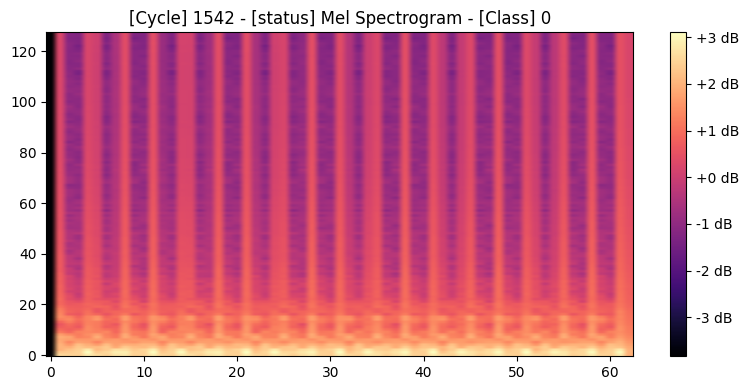

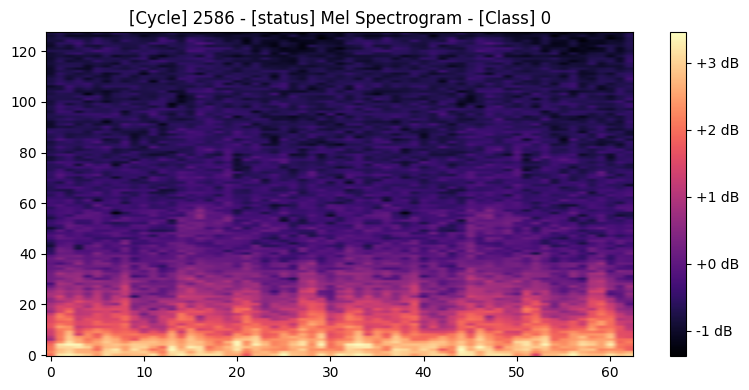

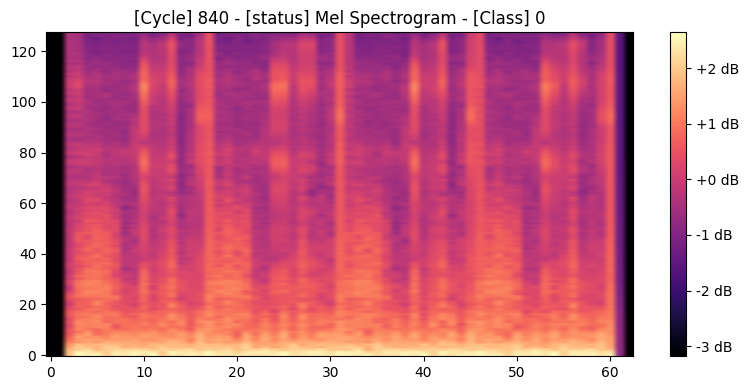

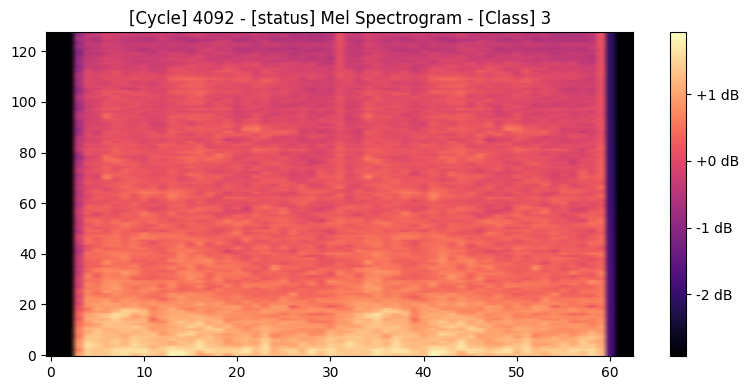

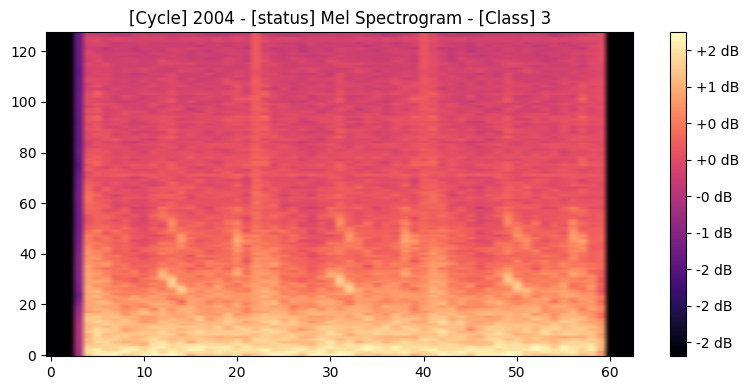

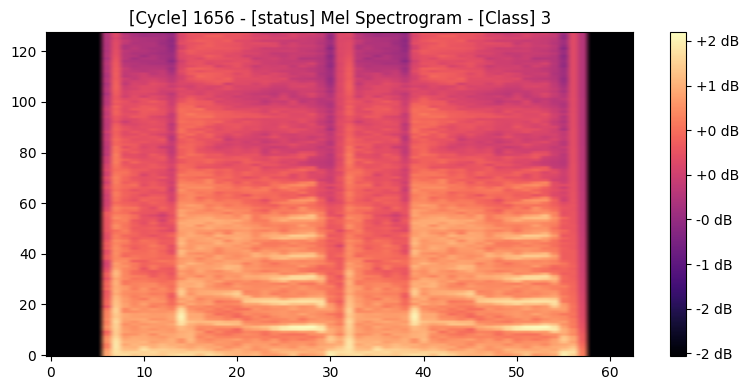

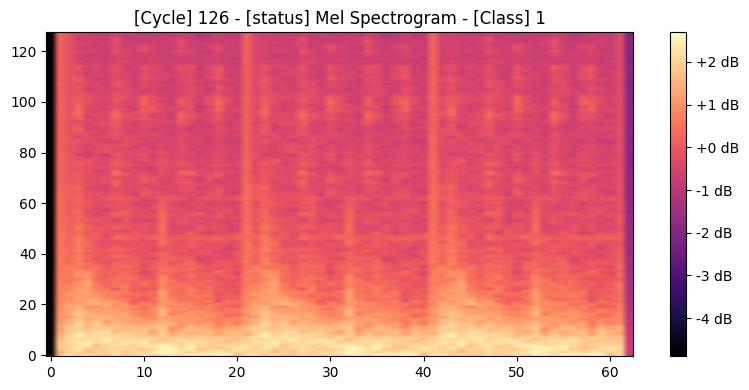

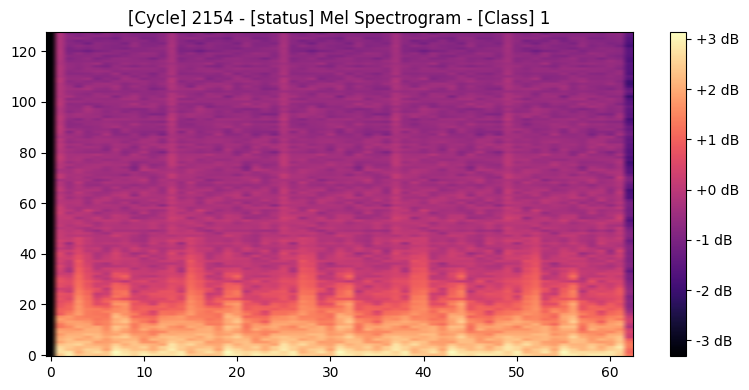

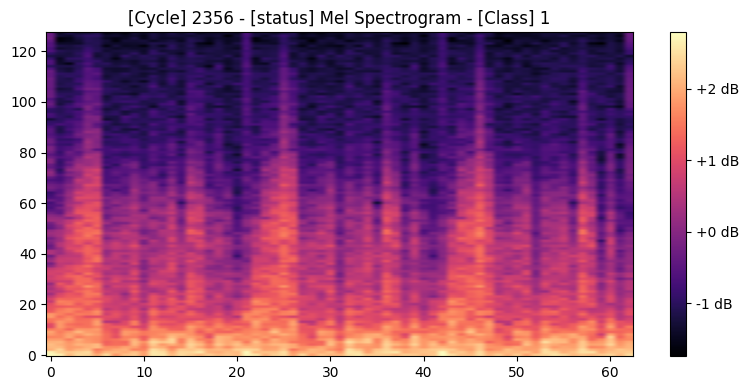

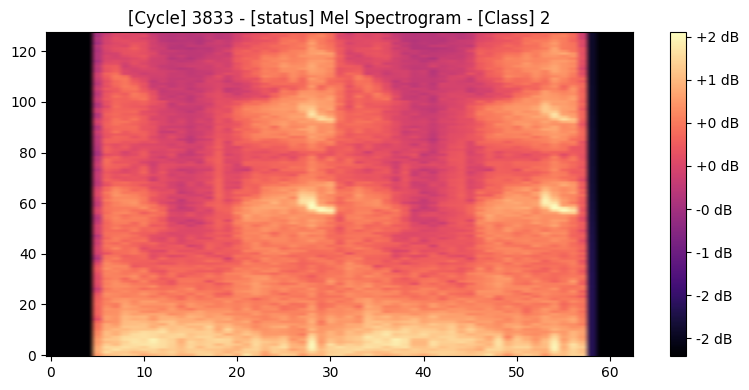

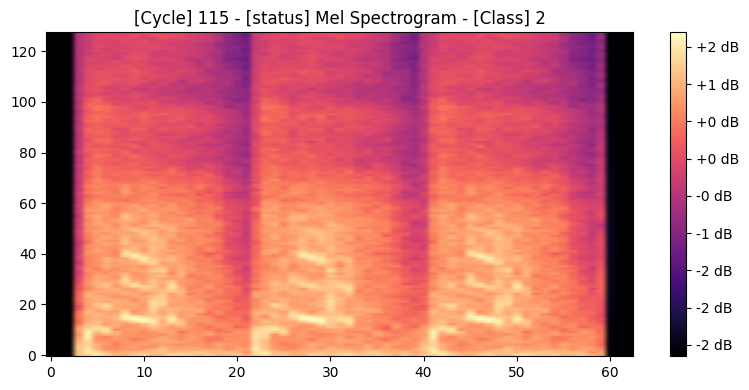

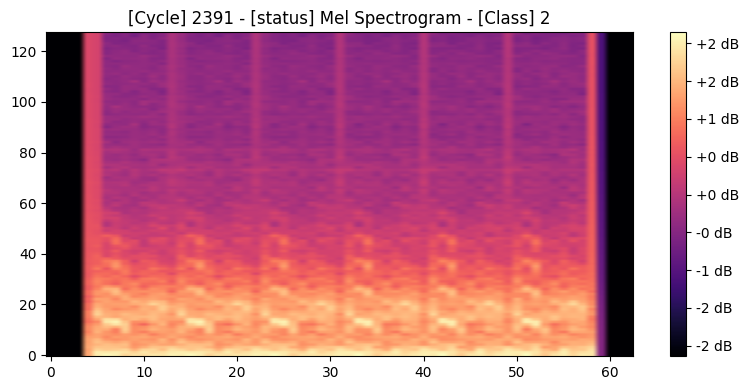

In [42]:
seed_everything(118)

label_to_indices = {multilabel_to_class(label): [] for label in set([train_dataset[idx][1] for idx in range(len(train_dataset))])}

for idx in range(len(train_dataset)):
    _, label, _ = train_dataset[idx]
    label_to_indices[multilabel_to_class(label)].append(idx)

plt.figure(figsize=(12, 6))

for i, (label, indices) in enumerate(label_to_indices.items()):
    # 각 label에서 샘플을 일정 횟수 랜덤하게 뽑기
    sample_indices = random.sample(indices, 3)

    for j, sample_idx in enumerate(sample_indices):
        mel, label, meta = train_dataset[sample_idx]

        if '-' in meta[0]:
            text = 'concat'
        else:
            text = 'Mel Spectrogram'
        
        # 시각화
        plt.figure(figsize=(8, 4))
        plt.imshow(mel.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
        plt.title(f"[Cycle] {sample_idx} - [status] {text} - [Class] {multilabel_to_class(label)}")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()

plt.show()

In [ ]:
for epoch in range(args.epochs):

    print(f"============ 현재 {epoch} epoch입니다. ============")
    for i, (repeat_mel, label, _) in enumerate(train_loader): 
        im_q, im_k, _ = window_mix(repeat_mel, mel_train_classwise_dict)
        print(f"first im_q: {im_q[0]}")
        print(im_q[0].shape)
        print(f"first im_k: {im_k[0]}")
        print(im_k[0].shape)

        if i == 0:
            break

    break

In [ ]:
seed_everything(args.seed)

for i in range(10):
    repeat_mel, label, meta = next(iter(train_loader))

    # 강한 증강
    im_q, im_k, _ = window_mix(repeat_mel, mel_train_classwise_dict)

    # 약한 증강
    im_q = apply_augmentations_torch(im_q, methods=["add_noise"], add_noise={"noise_level": 0.05})
    im_k = apply_augmentations_torch(im_k, methods=["time_stretch"], time_stretch={"min_rate": 0.9, "max_rate": 1.1})

    # 배치 단위 정규화
    im_q = (im_q - im_q.mean() ) / (im_q.std() + 1e-6)
    im_k = (im_k - im_k.mean() ) / (im_k.std() + 1e-6)

    mel1, mel2, cls = im_q[i], im_k[i], multilabel_to_class(label[i])

    if '-' in meta[0][i]:
        text = 'concat'
    else:
        text = 'origin'

    plt.figure(figsize=(14, 6))
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1행 2열

    # mel1
    im1 = axes[0].imshow(mel1.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
    axes[0].set_title(f"mel1: [status] {text} - [Class] {cls}")
    fig.colorbar(im1, ax=axes[0], format='%+2.0f dB')

    # mel2
    im2 = axes[1].imshow(mel2.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
    axes[1].set_title(f"mel2: [status] {text} - [Class] {cls}")
    fig.colorbar(im2, ax=axes[1], format='%+2.0f dB')

    plt.tight_layout()
    plt.show()